In [4]:
import os
import torch
import pandas as pd
from sklearn.model_selection import StratifiedGroupKFold
from torch_dataset import BreastCancerDataSet_Basic
from transforms import get_transforms
from training import train_model
from models import SimSiam, SimSiamWithAffine
import gc
import numpy as np
from training import extract_model_features

N_FOLDS = 5
IMG_SIZE = (256, 512)
MODEL_TYPE = "resnet50"
TARGET = 'cancer'
DEVICE = "cuda:0"

train_path = "/mnt/striped/kaggle/rsna_bcd/data/train.csv"
images_path = "/mnt/striped/kaggle/rsna_bcd/data/preprocessed_mp_aspectratio_768_384/"

os.environ["NCCL_BUFFSIZE"] = f"{64 * 1024 * 1024}"


In [8]:
# Load dataset
df_train = pd.read_csv(train_path)

# Set up the folds
split = StratifiedGroupKFold(N_FOLDS, random_state=42, shuffle=True)
for k, (_, test_idx) in enumerate(split.split(df_train, df_train.cancer, groups=df_train.patient_id)):
    df_train.loc[test_idx, 'split'] = k
df_train.split = df_train.split.astype(int)
df_train.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,split
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False,1
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False,1
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False,1
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False,1
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True,0


In [7]:
def load_model(model_type, affine, mixup, checkpoint, device):
    
    if affine:
        if mixup:
            raise ValueError("Affine and mixup are not compatible")

        model = SimSiamWithAffine(model_type = model_type, IMG_SIZE = IMG_SIZE)
    else:
        model = SimSiam(model_type = model_type, IMG_SIZE = IMG_SIZE)

    model.to(device)
    model = torch.nn.SyncBatchNorm.convert_sync_batchnorm(model)

    def adjust_key(key : str):
        if key.startswith("module."):
            return key[7:]
        else:
            return key
        
    state_dict = torch.load(checkpoint)
    state_dict = {adjust_key(k):v for k,v in state_dict.items()}
    model.load_state_dict(state_dict)

    return model

In [6]:
import torch.nn as nn
from torch.cuda.amp import GradScaler, autocast
from sklearn.metrics import roc_auc_score

def pfbeta(labels, predictions, beta):
    y_true_count = 0
    ctp = 0
    cfp = 0

    for idx in range(len(labels)):
        prediction = min(max(predictions[idx], 0), 1)
        if (labels[idx]):
            y_true_count += 1
            ctp += prediction
        else:
            cfp += prediction

    beta_squared = beta * beta
    c_precision = ctp / (ctp + cfp)
    c_recall = ctp / y_true_count
    if (c_precision > 0 and c_recall > 0):
        result = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall)
        return result
    else:
        return 0
    
def train_model_simple(model, ds_train, ds_eval,
                batch_size, device, epochs, sampler = None, 
                shuffle = True):
    
    num_workers = 6
    
    torch.manual_seed(42)
        
    print("Device", device)
    print("Setting up loader ...")

    dl_train = torch.utils.data.DataLoader(ds_train, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, 
                                           pin_memory=True, pin_memory_device=device, prefetch_factor=4, sampler=sampler)

    dl_eval = torch.utils.data.DataLoader(ds_eval, batch_size=batch_size, shuffle=False, num_workers=num_workers, 
                                           pin_memory=True, pin_memory_device=device, prefetch_factor=4, sampler=None)

    print("Setting up loader ... DONE")

    criterion = nn.BCEWithLogitsLoss()

    # use SGD with momentum and weight decay
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
    scheduler = None
    
    scaler = GradScaler()
    best_eval_score = 0

    avg_loss = 0.0
    aucs = []

    for epoch in range(epochs):

        model.train()
            
        optimizer.zero_grad(set_to_none=True)
        
        for x, y_cancer in dl_train:

            # Using mixed precision training
            with autocast():
                x = x.to(device)
                y_cancer = y_cancer.to(device)
                y_pred = model(x)
                loss = criterion(y_pred, y_cancer.float())
                
            # scaler is needed to prevent "gradient underflow"
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            
            # use moving averages to track the loss
            w = 0.9
            avg_loss = w * avg_loss + (1 - w) * loss.item()
             
        # print intermediate results
        print(
            f"[Epoch {epoch:3d}] "
            f"Loss = {avg_loss:.4f} "
        )
        
        if epoch % 2 == 0:
        
            model.eval()

            eval_preds = []
            eval_targets = []

            with torch.no_grad():

                for x, y_cancer in dl_eval:

                    x = x.to(device)
                    y_pred = model(x).squeeze()
                    y_pred = torch.sigmoid(y_pred)

                    eval_preds.extend(y_pred.tolist())
                    eval_targets.extend(y_cancer.tolist())

            auc = roc_auc_score(eval_targets, eval_preds)
            pf1= pfbeta(eval_targets, eval_preds, beta=1)
                        
            aucs.append(auc)

            print(f'AUC on test set: {auc:.2f}')
            print(f'PF1 on test set: {pf1:.2f}')

    return aucs
            



In [5]:
gc.collect()

0

In [9]:
import torch.nn as nn
from timm import create_model

def finetune_model(model_backbone, backbone_dim, epochs, device):

    # Create a simple binary classifier
    class BinaryClassificationModel(nn.Module):

        def __init__(self, backbone, backbone_dim):
            super(BinaryClassificationModel, self).__init__()
            self.backbone = backbone

            # Classification head
            self.classifier = nn.Sequential(
                nn.BatchNorm1d(backbone_dim),
                nn.ReLU(),
                nn.Linear(backbone_dim, 1)
            )
        
        def forward(self, x):
            # Get the features from the backbone
            features = self.backbone(x)
            # Classify
            output = self.classifier(features)
            output = output.squeeze()

            return output
        
    model_classifier = BinaryClassificationModel(model_backbone, backbone_dim)
    model_classifier = model_classifier.to(device)

    fold = 0

    ds_train = BreastCancerDataSet_Basic(df_train.query('split != @fold'), 
                                        images_path,
                                        TARGET = TARGET,
                                        transforms = get_transforms(True, IMG_SIZE))

    ds_eval = BreastCancerDataSet_Basic(df_train.query('split == @fold'), 
                                        images_path,
                                        TARGET = TARGET,
                                        transforms = get_transforms(False, IMG_SIZE))

    return train_model_simple(model_classifier, ds_train, ds_eval, 64, device, epochs)

epochs = 40

# Perform three different fine-tuning experiments: imagenet weights, normal weights, mixup weights
auc_finetune_none   = finetune_model(create_model(MODEL_TYPE, pretrained = True, num_classes = 0, drop_rate = 0., in_chans = 1), 2048, epochs, DEVICE)
auc_finetune_normal = finetune_model(load_model(MODEL_TYPE, False, False, "checkpoints/model_resnet50_bs_48_epoch_90.pt", DEVICE).backbone, 2048, epochs, DEVICE)
auc_finetune_mixup  = finetune_model(load_model(MODEL_TYPE, False, True,"checkpoints/model_resnet50_mixup_bs_48_epoch_90.pt", DEVICE).backbone, 2048, epochs, DEVICE)

Device cuda:0
Setting up loader ...
Setting up loader ... DONE
[Epoch   0] Loss = 0.0994 
AUC on test set: 0.55
PF1 on test set: 0.02
[Epoch   1] Loss = 0.0828 
[Epoch   2] Loss = 0.0650 
AUC on test set: 0.58
PF1 on test set: 0.02
[Epoch   3] Loss = 0.0933 
[Epoch   4] Loss = 0.0945 
AUC on test set: 0.61
PF1 on test set: 0.03
[Epoch   5] Loss = 0.0934 
[Epoch   6] Loss = 0.0967 
AUC on test set: 0.60
PF1 on test set: 0.03
[Epoch   7] Loss = 0.0871 
[Epoch   8] Loss = 0.0847 
AUC on test set: 0.62
PF1 on test set: 0.03
[Epoch   9] Loss = 0.0692 
[Epoch  10] Loss = 0.1027 
AUC on test set: 0.64
PF1 on test set: 0.03
[Epoch  11] Loss = 0.0812 
[Epoch  12] Loss = 0.0769 
AUC on test set: 0.65
PF1 on test set: 0.03
[Epoch  13] Loss = 0.0955 
[Epoch  14] Loss = 0.0839 
AUC on test set: 0.63
PF1 on test set: 0.03
[Epoch  15] Loss = 0.1049 
[Epoch  16] Loss = 0.0956 
AUC on test set: 0.67
PF1 on test set: 0.04
[Epoch  17] Loss = 0.0922 
[Epoch  18] Loss = 0.1385 
AUC on test set: 0.67
PF1 on

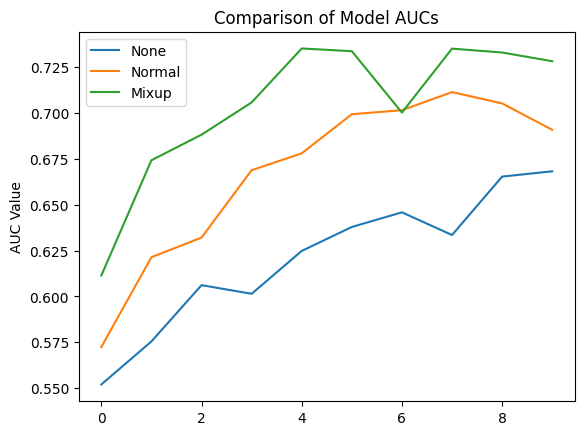

In [16]:
import matplotlib.pyplot as plt

l = 10
x = range(l)

plt.plot(x, auc_finetune_none[:l], label='None')
#plt.plot(x, auc_finetune_affine, label='Affine')
plt.plot(x, auc_finetune_normal[:l], label='Normal')
plt.plot(x, auc_finetune_mixup[:l], label='Mixup')

# Adding title and labels
plt.title('Comparison of Model AUCs')
plt.ylabel('AUC Value')

# Add a legend to the plot
plt.legend()

# Display the plot
plt.show()